## Bayesian Analysis of Canadian P&C Insurance Historical Loss Ratios

The Purpose of the notebook is to demonstrate how Bayesian statistical analysis can be used to model Canadian P&C Insurance loss ratios based on historical data from 2011 to 2021 (publicly available from OSFI website). The analysis is done using Pymc3.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data=pd.read_csv('PnC insurance industry LRs.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  495 non-null    object 
 1   Region   495 non-null    object 
 2   Year     495 non-null    int64  
 3   EP       495 non-null    int64  
 4   Claims   495 non-null    float64
 5   LR       495 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 23.3+ KB


In [3]:
data['Year']=data['Year'].astype(int)
data['Territories?']=False
data.loc[data['Region']=='Territories','Territories?']=True

The dataset contains earned premium (EP), claims and loss ratio (LR = claims divided by premium) of the top 9 P&C insurers in Canada by each of the 5 regions from year 2011 to 2021. As shown in the histogram chart below, the LRs distribution is not quite normal: it has about a dozen observations close to 0 and a very long right tail. The boxplot shows the distribution of the LRs for each region - it is obvious that Territories have seen quite volatile LRs while the other regions seem to, more or less, follow a normal distribution.

In [4]:
data.describe()

,Year,EP,Claims,LR
count,495.000000,4.950000e+02,4.950000e+02,495.000000
mean,2016.000000,6.424848e+05,4.093609e+05,0.669181
std,3.165477,8.011142e+05,5.266534e+05,0.263231
min,2011.000000,1.300000e+02,6.500000e-02,0.000100
25%,2013.000000,7.734900e+04,4.214100e+04,0.579450
50%,2016.000000,3.309070e+05,1.863910e+05,0.654400
75%,2019.000000,9.995855e+05,5.944425e+05,0.755850
max,2021.000000,3.988278e+06,2.822573e+06,4.034200


In [5]:
data.sample(5)

,Company,Region,Year,EP,Claims,LR,Territories?
331,TD Insurance,Atlantic,2012,134676,83694.0,0.6214,False
434,Travelers,West,2016,334341,399650.0,1.1953,False
414,Travelers,Quebec,2018,50562,46356.0,0.9168,False
81,Aviva,Quebec,2015,490710,308646.0,0.6290,False
172,Economical,Atlantic,2018,172401,147878.0,0.8578,False


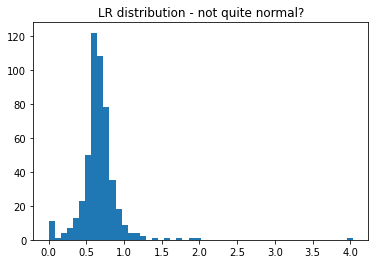

In [6]:
plt.hist(data['LR'],bins=50)
plt.title('LR distribution - not quite normal?')
plt.show()

<AxesSubplot:xlabel='Region', ylabel='LR'>

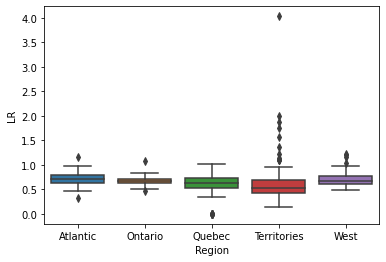

In [7]:
sns.boxplot(data=data,x='Region',y='LR')

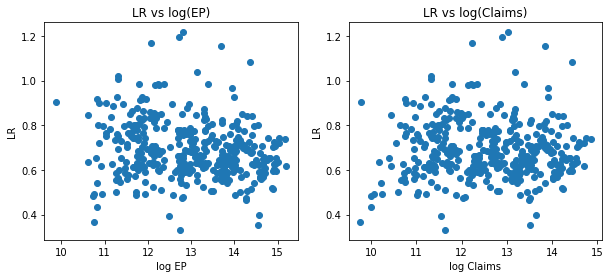

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))

ax1.scatter(np.log(data['EP']),data['LR'])
ax1.set_xlabel('log EP')
ax1.set_ylabel('LR')
ax1.set_title('LR vs log(EP)')

ax2.scatter(np.log(data['Claims']),data['LR'])
ax2.set_xlabel('log Claims')
ax2.set_ylabel('LR')
ax2.set_title('LR vs log(Claims)')

plt.show()

### 1. Mixsure Model
The motivation of modeling the LRs as mixsure model is to capture the volatile LR distribution of Territories from the other regions, which seem to be relatively normal. This is done by combining two normal distributions with a proportion parameter. The *mu* and *sigma* of the two Normal distribution are to be estimated along with the proportion *p (and 1-p)* of each distribution. The the priori distribution for the *p* parameter is set to Beta distribution (as a special case of Dirichlet) and the category of which of the two Normal distribution a data point belongs to is modeled as a Categorical (multinomial) distribution. To resolve the identity/symmetry issue, a "potential" function is added to ensure the *sigma* of the first Normal distribution is larger than the second. The graphical representation of the mixsure model is shown below.       

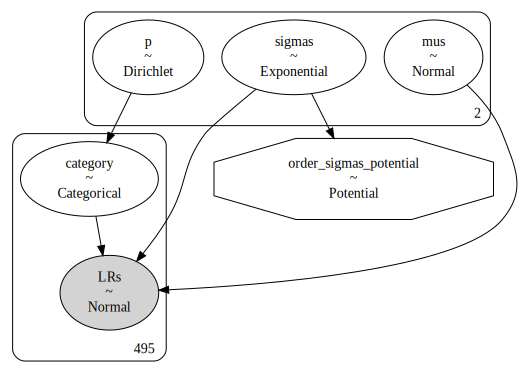

In [9]:
with pm.Model() as model_mixsure:    
    p = pm.Dirichlet('p',np.array([.5,.5]),shape=2)
    category = pm.Categorical('category',p=p,shape=len(data['LR']))
    
    mus = pm.Normal('mus',mu=0.,sigma=1.,shape=2)
    sigmas = pm.Exponential('sigmas',[1.,1.],shape=2)
    
    order_sigmas_potential = pm.Potential("order_sigmas_potential",tt.switch(sigmas[1] - sigmas[0] < 0, -np.inf, 0))
    LRs = pm.Normal('LRs',mu=mus[category],sigma=sigmas[category],observed=data['LR'])
        
pm.model_graph.model_to_graphviz(model_mixsure,formatting='plain')

The MCMC approach is to combine Metropolis for the continuous parameters and element wise categorical for discrete parameter (caetgory). The *trace* (posteriori samples) should have a *rhat* close to 1 and no sigificant signs of autocorrelation between the consecutive samples as shown in the trace plot.

In [10]:
with model_mixsure:
    step1 = pm.Metropolis(vars=[p,mus,sigmas])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1])
    trace = pm.sample(10000, step=[step1, step2], tune=5000)
arviz.summary(trace,var_names=['p','mus','sigmas'])

<ipython-input-10-634e5ba5b2f6>:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1])
<ipython-input-10-634e5ba5b2f6>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, step=[step1, step2], tune=5000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sigmas]
>>Metropolis: [mus]
>>Metropolis: [p]
>ElemwiseCategorical: [category]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 106 seconds.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.876,0.026,0.825,0.923,0.001,0.001,1036.0,1036.0,1047.0,2337.0,1.00
p[1],0.124,0.026,0.077,0.175,0.001,0.001,1036.0,1033.0,1047.0,2337.0,1.00
mus[0],0.664,0.007,0.651,0.677,0.000,0.000,5814.0,5814.0,5825.0,7213.0,1.00
mus[1],0.703,0.096,0.519,0.883,0.007,0.005,196.0,191.0,201.0,270.0,1.01
sigmas[0],0.130,0.007,0.117,0.143,0.000,0.000,1203.0,1203.0,1201.0,2643.0,1.00
sigmas[1],0.689,0.086,0.540,0.854,0.003,0.002,901.0,901.0,906.0,1819.0,1.00


/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'sigmas'}>,
        <AxesSubplot:title={'center':'sigmas'}>],
       [<AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'mus'}>]], dtype=object)

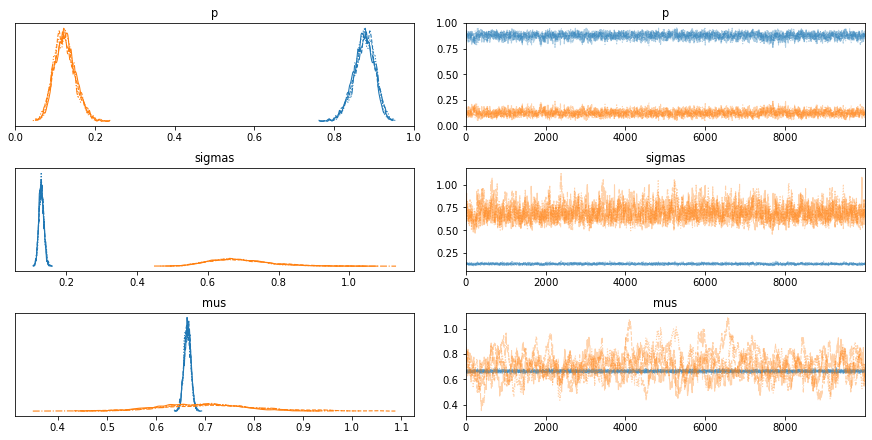

In [11]:
arviz.plot_trace(trace,var_names=(['p','sigmas','mus']))

In [12]:
data['category_mean']=arviz.summary(trace,var_names=['category'])['mean'].values
data['category_sd']=arviz.summary(trace,var_names=['category'])['sd'].values

/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / 

The results seem to have converged and look reasonable: the proportion *p* of the first Normal distribution accounts for about 10% with a higher *sigma* although with higher uncertainty, similar for *mu*. To compare the model results with the actual LR distribution, I plotted the modeled mean category score (0/1) against the actual LR for Territories and other regions. The model does a decent job identifying the LRs for Territories (in orange) without any additional information other than the LRs themselves. It is interesting to note that the standard deviation of the category score is considerably lower for the right tail - the model is fairly certain about the category for the very high LRs.  

Text(0.5, 1.0, 'Category vs LR')

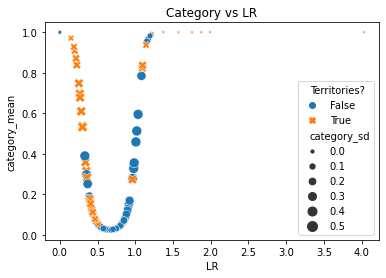

In [13]:
sns.scatterplot(data=data,x='LR',y='category_mean',hue='Territories?'
                ,style='Territories?',size='category_sd',sizes=(10,100)).set_title('Category vs LR')

### 2. Bayesian A/B Test

#### 2.1 Bayesian A/B Test: LRs Quebec vs. other regions
Now that we know Territories have a signicant different LR distribution than other regions, we dropped Territories data and continue to look at the LRs for each region below. It turned out Quebec has a dozen LRs close to 0 all belonging to a specific company, which suggests there is a data error (either the source data or via data manipulation). Let's keep these data points in for now. We are interested in comparing Quebec LR distribution against other regions - a Bayesian A/B test! 

In [14]:
data=data[data['Territories?']==False]
data=data.iloc[:,0:6]
data['Quebec?']=False
data.loc[data['Region']=='Quebec','Quebec?']=True
data.sample(5)

,Company,Region,Year,EP,Claims,LR,Quebec?
435,Travelers,West,2017,336507,240958.000,0.7161,False
113,Desjardins,Atlantic,2014,57982,46147.000,0.7959,False
345,TD Insurance,Ontario,2015,1811219,1366140.000,0.7543,False
103,Aviva,West,2015,1145875,700217.000,0.6111,False
135,Desjardins,Quebec,2014,1179390,0.065,0.0001,True


In [15]:
data[data['LR']<0.001]

,Company,Region,Year,EP,Claims,LR,Quebec?
132,Desjardins,Quebec,2011,1019150,0.065,0.0001,True
133,Desjardins,Quebec,2012,1066528,0.065,0.0001,True
134,Desjardins,Quebec,2013,1126661,0.065,0.0001,True
135,Desjardins,Quebec,2014,1179390,0.065,0.0001,True
136,Desjardins,Quebec,2015,1255791,0.065,0.0001,True
137,Desjardins,Quebec,2016,1330677,0.065,0.0001,True
138,Desjardins,Quebec,2017,1412204,0.065,0.0001,True
139,Desjardins,Quebec,2018,1514601,0.065,0.0001,True
140,Desjardins,Quebec,2019,1689418,0.065,0.0001,True
141,Desjardins,Quebec,2020,1868480,0.065,0.0001,True


<AxesSubplot:xlabel='LR', ylabel='Count'>

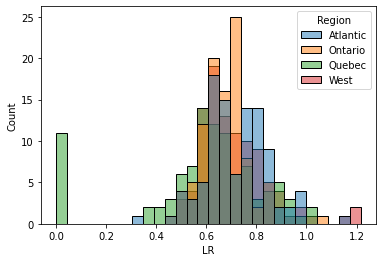

In [16]:
sns.histplot(data=data,x='LR',hue='Region')

In [17]:
company_idxs, companies = pd.factorize(data['Company'],sort=True)
region_idxs, regions = pd.factorize(data['Region'],sort=True)
obs_idxs = np.arange(len(data))

coords = {'company':companies,
         'region':regions,
         'obs_id':obs_idxs}
print('region:{};\ncompany:{};'.format(regions.values,companies.values))

region:['Atlantic' 'Ontario' 'Quebec' 'West'];
company:['Allstate' 'Aviva' 'Desjardins' 'Economical' 'Intact' 'RSA'
 'TD Insurance' 'Travelers' 'Wawanesa'];


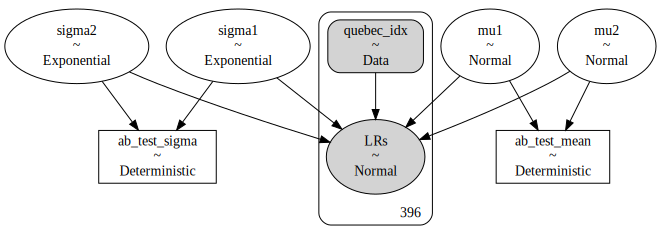

In [18]:
with pm.Model() as model_ab_test:
    quebec_idx = pm.Data('quebec_idx',data['Quebec?'])
    mu1 = pm.Normal('mu1',mu=0.,sigma=1.)
    mu2 = pm.Normal('mu2',mu=0.,sigma=1.)
    sigma1 = pm.Exponential('sigma1',1.)
    sigma2 = pm.Exponential('sigma2',1.)
    
    mu = pm.math.switch(quebec_idx, mu1, mu2)
    sigma = pm.math.switch(quebec_idx, sigma1, sigma2)
    ab_test_mean = pm.Deterministic('ab_test_mean',mu1-mu2)
    ab_test_sigma = pm.Deterministic('ab_test_sigma',sigma1-sigma2)
    
    LRs = pm.Normal('LRs', mu=mu, sigma=sigma, observed=data['LR'])

pm.model_graph.model_to_graphviz(model_ab_test)

The results below showed the A/B test difference between the mean of the LR distribution is almost definitely below zero and the difference in the sigma above zero. This confirms our initial belief Quebec is quite different from the other regions. However, this is still including the dozen of incorrect data points. Next we would like to label these dozen of data points are missing data, which allows us to see how Bayesian impute missing data automatically (thanks to the Bayesian approach of treating each data point as a parameter distribution!).

<ipython-input-19-d80cf48b8e79>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000,tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2, sigma1, mu2, mu1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 9 seconds.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'sigma1'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'ab_test_mean'}>,
        <AxesSubplot:title={'center':'ab_test_sigma'}>]], dtype=object)

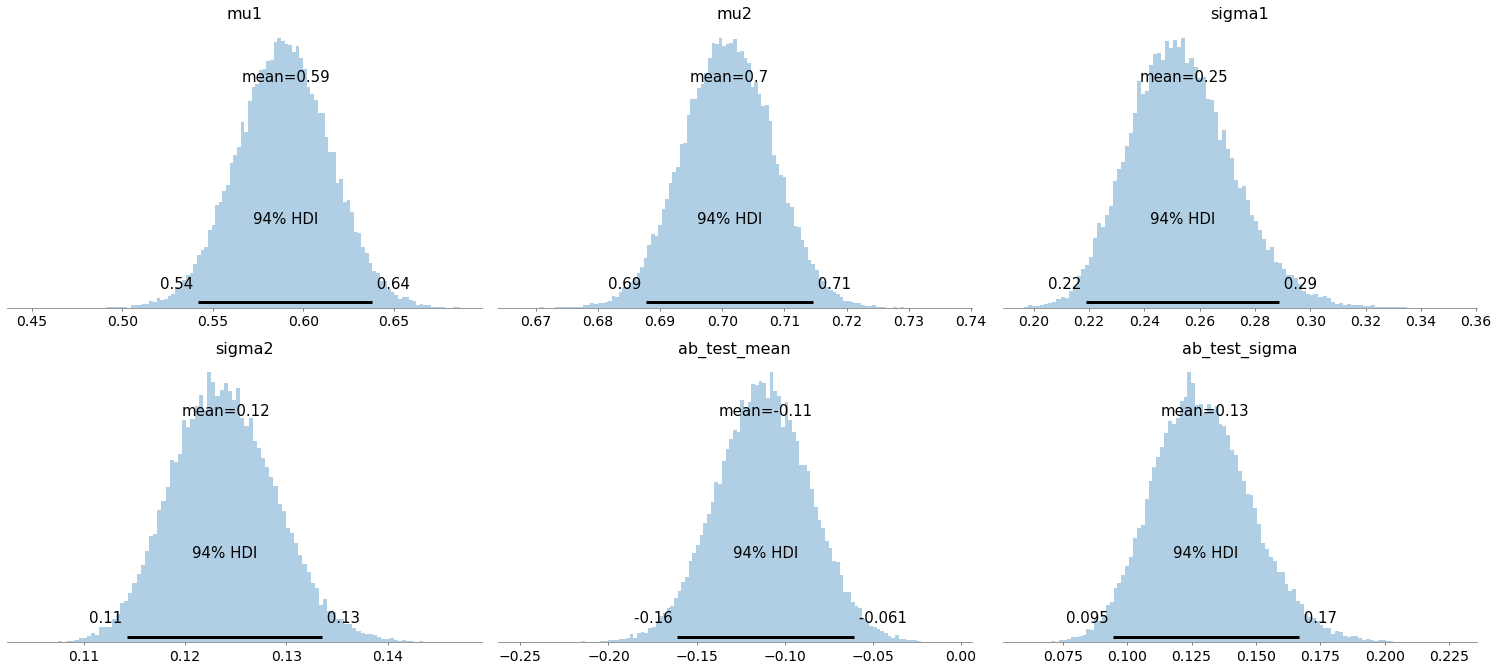

In [19]:
with model_ab_test:
    trace = pm.sample(10000,tune=5000)
arviz.plot_posterior(trace,kind='hist')

#### 2.2 Bayesian Model Imputes Missing Data automatically
We first changed the dozen incorrect data points to missing in the dataset and use the same model used for A/B test above to impute the missing data. Note however the imputation is necessarily a great one because the model only captures the difference between Quebec and other regions, nothing else like the company or premium earned etc., which can be used to improve the imputation, but it is sufficent to illustrate the point here.

In [20]:
data.loc[data['LR']<0.001,'LR']=np.nan

In [21]:
with pm.Model() as model_missing_data:
    quebec_idx = pm.Data('quebec_idx',data['Quebec?'])
    mu1 = pm.Normal('mu1',mu=0.,sigma=1.)
    mu2 = pm.Normal('mu2',mu=0.,sigma=1.)
    sigma1 = pm.Exponential('sigma1',1.)
    sigma2 = pm.Exponential('sigma2',1.)
    
    mu = pm.math.switch(quebec_idx, mu1, mu2)
    sigma = pm.math.switch(quebec_idx, sigma1, sigma2)
    ab_test_mean = pm.Deterministic('ab_test_mean',mu1-mu2)
    ab_test_sigma = pm.Deterministic('ab_test_sigma',sigma1-sigma2)
    
    LRs = pm.Normal('LRs', mu=mu, sigma=sigma, observed=data['LR'])

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in LRs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


<ipython-input-22-256b02ed38a3>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000,tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LRs_missing, sigma2, sigma1, mu2, mu1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 13 seconds.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'LRs_missing\n0'}>,
        <AxesSubplot:title={'center':'LRs_missing\n1'}>,
        <AxesSubplot:title={'center':'LRs_missing\n2'}>],
       [<AxesSubplot:title={'center':'LRs_missing\n3'}>,
        <AxesSubplot:title={'center':'LRs_missing\n4'}>,
        <AxesSubplot:title={'center':'LRs_missing\n5'}>],
       [<AxesSubplot:title={'center':'LRs_missing\n6'}>,
        <AxesSubplot:title={'center':'LRs_missing\n7'}>,
        <AxesSubplot:title={'center':'LRs_missing\n8'}>],
       [<AxesSubplot:title={'center':'LRs_missing\n9'}>,
        <AxesSubplot:title={'center':'LRs_missing\n10'}>, <AxesSubplot:>]],
      dtype=object)

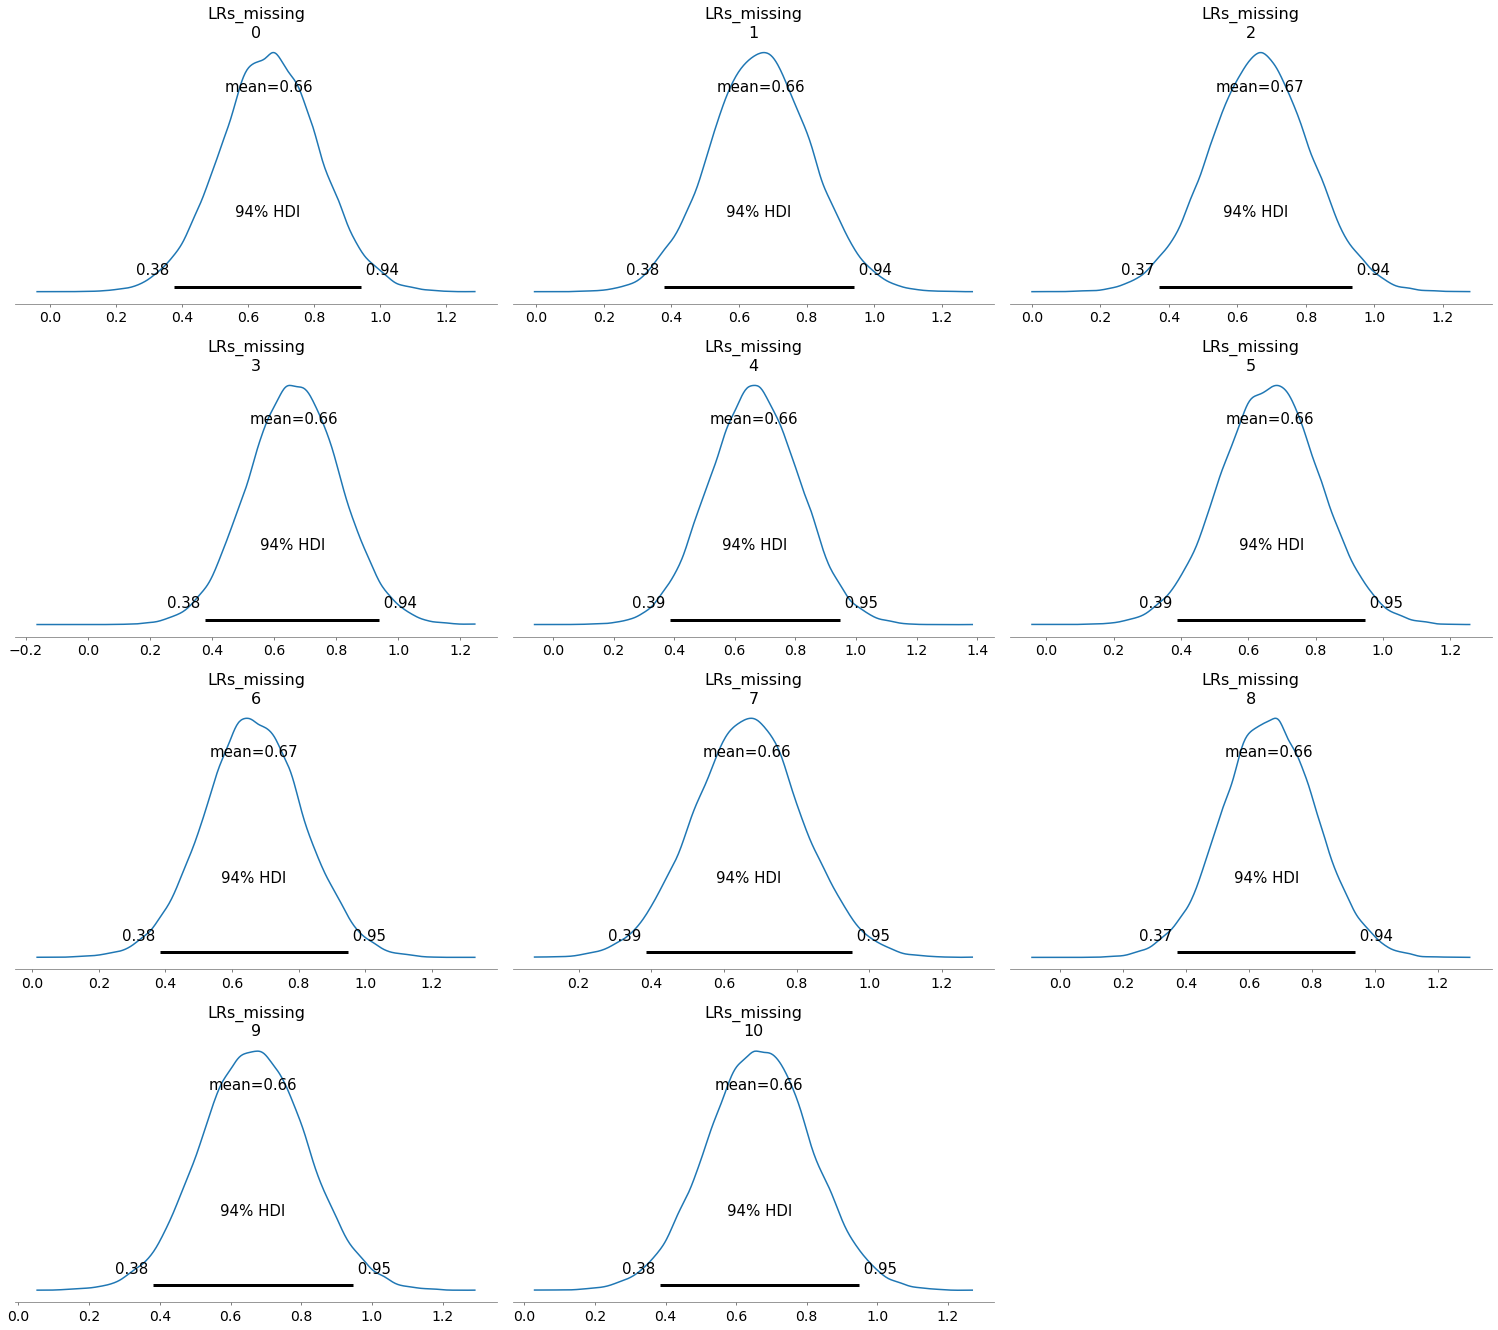

In [22]:
with model_missing_data:
    trace = pm.sample(10000,tune=5000)
arviz.plot_posterior(trace,var_names=['LRs_missing'],kind='kde')

#### 2.3 Second A/B Test: LRs before and after a specific year
While it does not seem to have a visually obvious pattern, we are interested in performing a A/B test to see if there is a change in the LR distribution before and after a specific year. This is to illustrate that the year can be modeled as a parameter of the Bayesian model. The model results did not find a year in between 2011 and 2021 that clearly differentiate the LR distributions before and after. 

Text(0.5, 1.0, 'LR by year')

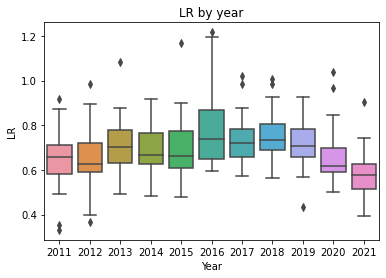

In [23]:
sns.boxplot(data=data,x='Year',y='LR').set_title('LR by year')

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in LRs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


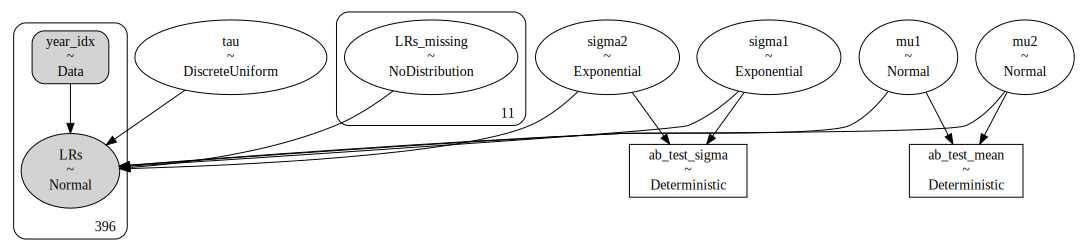

In [24]:
with pm.Model() as model_ab_test_2:
    year_idx = pm.Data('year_idx',data['Year'])
    tau = pm.DiscreteUniform('tau',2011,2021)
    mu1 = pm.Normal('mu1',mu=0.,sigma=1.)
    mu2 = pm.Normal('mu2',mu=0.,sigma=1.)
    sigma1 = pm.Exponential('sigma1',1.)
    sigma2 = pm.Exponential('sigma2',1.)
    
    mu = pm.math.switch(tau > year_idx, mu1, mu2)
    sigma = pm.math.switch(tau > year_idx, sigma1, sigma2)
    ab_test_mean = pm.Deterministic('ab_test_mean',mu1-mu2)
    ab_test_sigma = pm.Deterministic('ab_test_sigma',sigma1-sigma2)
    
    LRs = pm.Normal('LRs', mu=mu, sigma=sigma, observed=data['LR'])

pm.model_graph.model_to_graphviz(model_ab_test_2)

<ipython-input-25-c2b7c09878d5>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000,tune=5000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [LRs_missing, sigma2, sigma1, mu2, mu1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 20 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9259842613969637, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'mu2'}>],
       [<AxesSubplot:title={'center':'LRs_missing'}>,
        <AxesSubplot:title={'center':'LRs_missing'}>],
       [<AxesSubplot:title={'center':'sigma1'}>,
        <AxesSubplot:title={'center':'sigma1'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'ab_test_mean'}>,
        <AxesSubplot:title={'center':'ab_test_mean'}>],
       [<AxesSubplot:title={'center':'ab_test_sigma'}>,
        <AxesSubplot:title={'center':'ab_test_sigma'}>]], dtype=object)

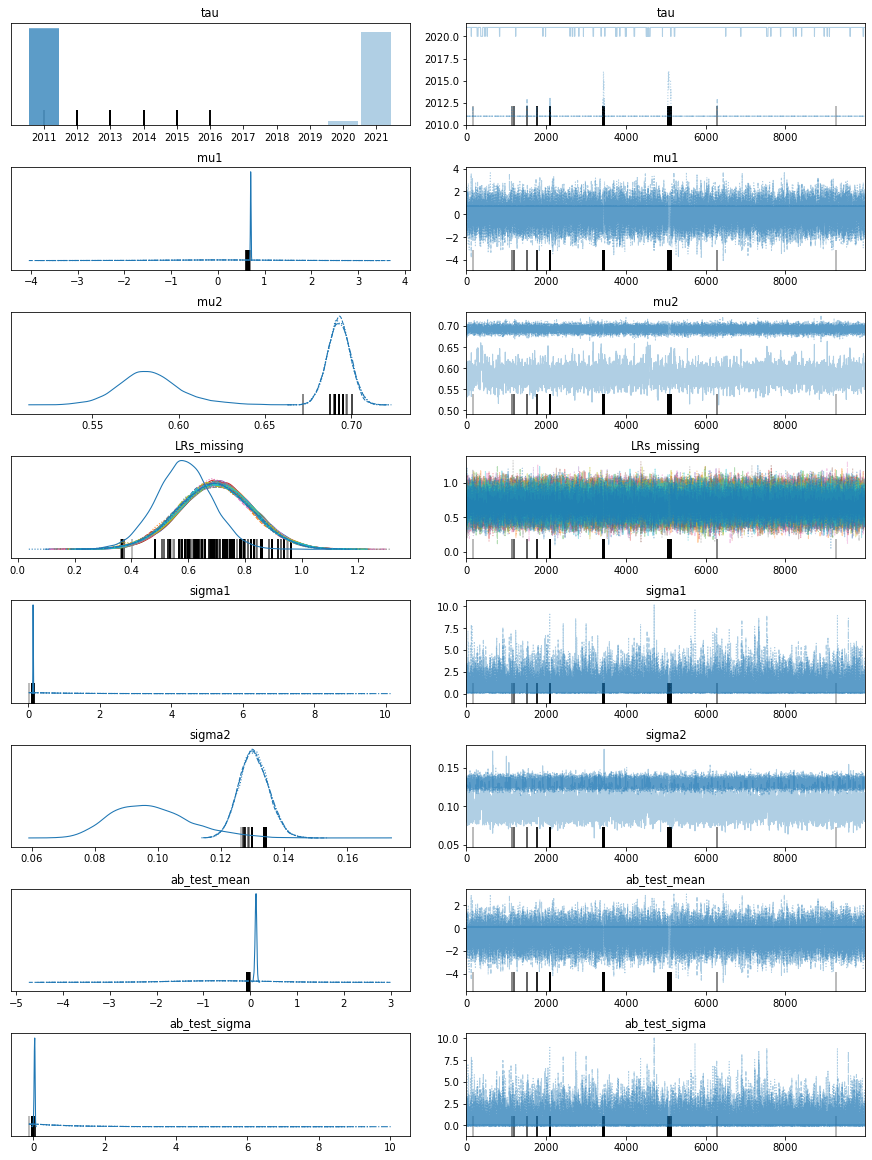

In [25]:
with model_ab_test_2:
    trace = pm.sample(10000,tune=5000)
arviz.plot_trace(trace)

### 3. Multi-level or Hiearchical Model
In the above, we only used the information of region by modeling different LR distributions for different regions through a mixture model. When we have additional information of company, earned premium etc., there is a more efficent modeling approach to use the additional information - you guessed it multilevel or hiearchical model. 

The motivation of multilevel model is take advantage of/avoid disvantage of pooling data (no consideration of region, company, year the data points come from etc.) and completely separating data into individual datasets based on attributes (again region, company, year etc. and therefore ignoring the similarity and correlations among separate datasets). This is done by allowing the lower level models to use separate datasets, which then are used to infer the higher level model(s) considering the similarity or correlations of the lower level models. A different angel to look at multilevel models is that the higher level model(s) act as a regularization for the lower level models - this is often observed through the *"shrinkage"* effect.

Below, we implemented three multilevel models. The first is a simple two level model with the lower level modeling each company LRs and higher one modeling the "industry" based on the lower level models. The second model adds region effect to the first model. The last one models the impact to LRs from premium - the higher the premium lower the volatility of the LRs simply due to diversification that comes with higher volume. It is similar to a traditional GLM Tweedie model. It is interesting to see how the imputed value for the missing data becomes more specific to the additional information being added into the more sophiscated model.  

#### 3.1 Simple multilevel model: Company
In this model, company level models are considered as lower level and "industry" level is considered as higher level model.

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in LR contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


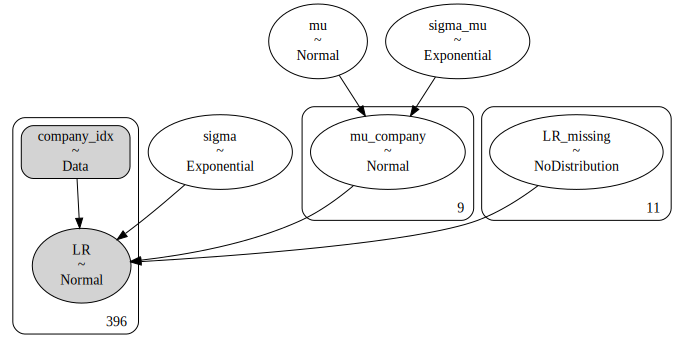

In [26]:
with pm.Model(coords=coords) as model_multilevel_1:
    company_idx = pm.Data('company_idx',company_idxs,dims='obs_id')
    
    mu = pm.Normal('mu',mu=0.,sigma=1.)
    sigma_mu = pm.Exponential('sigma_mu',1.)
    mu_company = pm.Normal('mu_company',mu=mu,sigma=sigma_mu,dims='company')

    sigma = pm.Exponential('sigma',1.)
    
    LR = pm.Normal('LR',mu=mu_company[company_idx],sigma=sigma,observed=data['LR'])

pm.model_to_graphviz(model_multilevel_1)

<ipython-input-27-f5d8ffdf252a>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000,tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LR_missing, sigma, mu_company, sigma_mu, mu]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 16 seconds.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'mu_company'}>,
        <AxesSubplot:title={'center':'mu_company'}>],
       [<AxesSubplot:title={'center':'LR_missing'}>,
        <AxesSubplot:title={'center':'LR_missing'}>],
       [<AxesSubplot:title={'center':'sigma_mu'}>,
        <AxesSubplot:title={'center':'sigma_mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

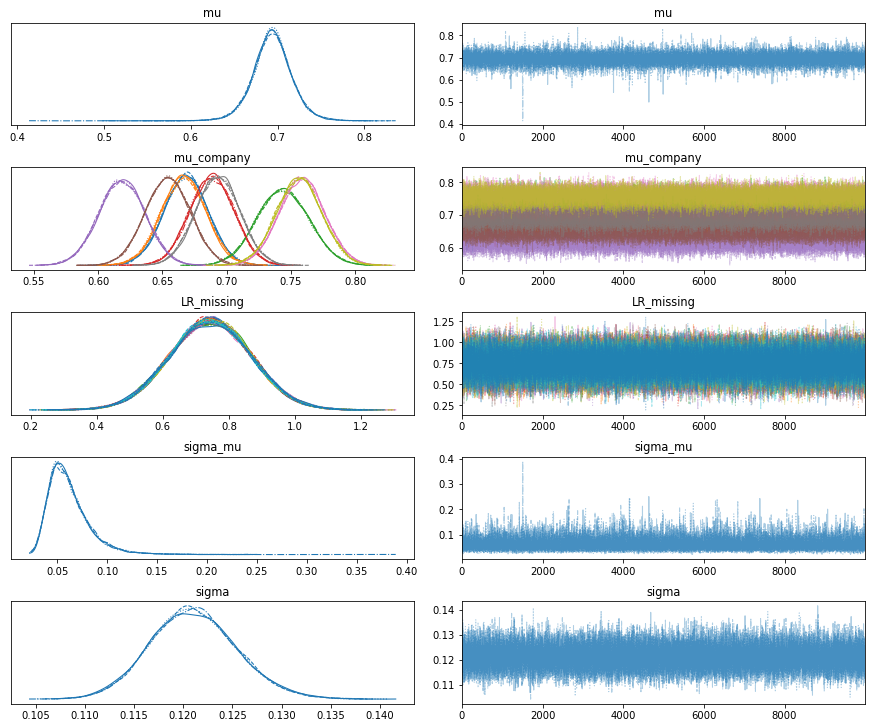

In [27]:
with model_multilevel_1:
    trace = pm.sample(10000,tune=5000)
arviz.plot_trace(trace)

#### 3.2 Multilevel model with additonal region impact
This model is the same as the above but with impact from region, however not the combination of the company and region.

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in LR contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


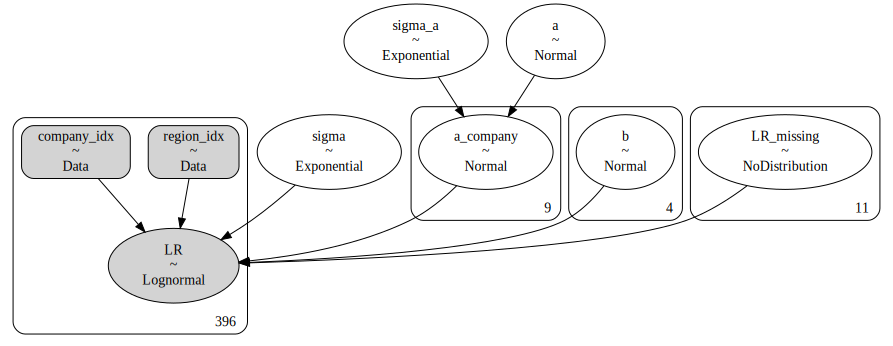

In [28]:
with pm.Model(coords=coords) as model_multilevel_2:
    company_idx = pm.Data('company_idx',company_idxs,dims='obs_id')
    region_idx = pm.Data('region_idx',region_idxs,dims='obs_id')
    
    a = pm.Normal('a',mu=0.,sigma=1.)
    sigma_a = pm.Exponential('sigma_a',1.)
    a_company = pm.Normal('a_company',mu=a,sigma=sigma_a,dims='company')
    
    b = pm.Normal('b',mu=0.,sigma=10.,dims='region')
    
    mu = a_company[company_idx] + b[region_idx]
    sigma = pm.Exponential('sigma',1.)
    
    LR = pm.Lognormal('LR',mu=mu,sigma=sigma,observed=data['LR'])

pm.model_to_graphviz(model_multilevel_2)

In [29]:
with model_multilevel_2:
    trace = pm.sample()
arviz.summary(trace)

<ipython-input-29-0a1f055ff1e2>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LR_missing, sigma, b, a_company, sigma_a, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.034,1.016,-1.838,1.944,0.056,0.039,333.0,333.0,334.0,716.0,1.01
a_company[0],0.004,1.017,-1.885,1.901,0.056,0.039,333.0,333.0,334.0,700.0,1.01
a_company[1],0.002,1.017,-1.890,1.902,0.056,0.039,333.0,333.0,334.0,698.0,1.01
a_company[2],0.091,1.018,-1.819,1.978,0.056,0.039,333.0,333.0,334.0,690.0,1.01
a_company[3],0.031,1.017,-1.876,1.919,0.056,0.039,333.0,333.0,334.0,701.0,1.01
a_company[4],-0.082,1.016,-1.983,1.801,0.056,0.039,333.0,333.0,334.0,689.0,1.01
a_company[5],-0.016,1.018,-1.905,1.887,0.056,0.039,333.0,333.0,335.0,714.0,1.01
a_company[6],0.122,1.018,-1.748,2.041,0.056,0.040,332.0,332.0,334.0,710.0,1.01
a_company[7],0.028,1.017,-1.823,1.968,0.056,0.039,333.0,333.0,334.0,708.0,1.01
a_company[8],0.127,1.018,-1.743,2.055,0.056,0.039,332.0,332.0,334.0,703.0,1.01


#### 3.3. Multilevel model with impact from EP
This model considers the earned premium impact to the modeling of LRs - volatility parameter of the LR distribution to be specific. We want to capture the effect of lower LR volatility in relation to higher premium. It is similar to a traditional GLM Tweedie model. As shown below, the *gamma (or power)* parameter is almost certain to be negative, confirming the hypothesis.

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in LR contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


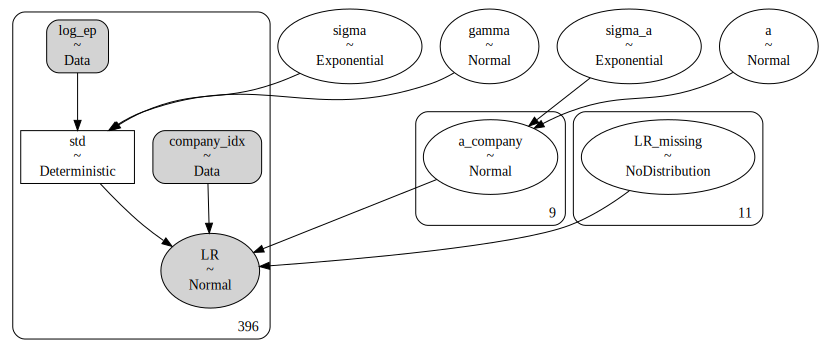

In [30]:
with pm.Model(coords=coords) as model_multilevel_3:
    company_idx = pm.Data('company_idx',company_idxs,dims='obs_id')
    log_ep = pm.Data('log_ep',np.log(data['EP']),dims='obs_id')
    
    a = pm.Normal('a',mu=0.,sigma=10.)
    sigma_a = pm.Exponential('sigma_a',1.)
    a_company = pm.Normal('a_company',mu=a,sigma=sigma_a,dims='company')
    
    mu = a_company[company_idx]
    sigma = pm.Exponential('sigma',1.)
    
    gamma = pm.Normal('gamma',mu=0.,sigma=10.)
    std = pm.Deterministic('std',sigma * log_ep**gamma)
    
    LR = pm.Normal('LR',mu=mu,sigma=std,observed=data['LR'])

pm.model_to_graphviz(model_multilevel_3)

<ipython-input-31-498d7c1cd6d9>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LR_missing, gamma, sigma, a_company, sigma_a, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8861230580884945, but should be close to 0.8. Try to increase the number of tuning steps.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'a_company'}>,
        <AxesSubplot:title={'center':'a_company'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

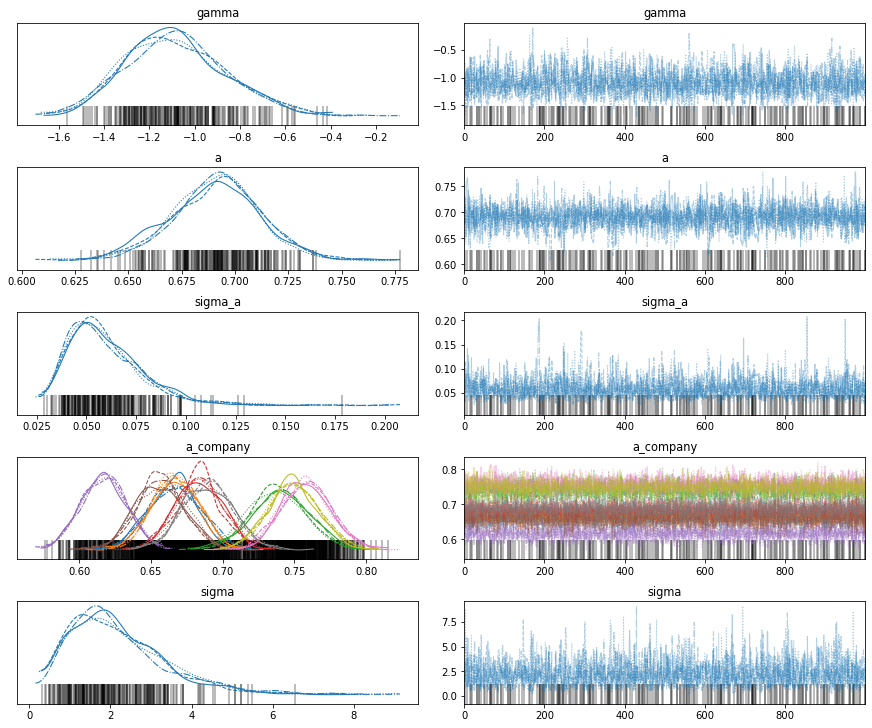

In [31]:
with model_multilevel_3:
    trace = pm.sample()
arviz.plot_trace(trace,var_names=['gamma','a','sigma_a','a_company','sigma'])

Gamma the tweedie power estimate is significantly different less than zero.

### 4. Multivariate model with LKJ Covariance priors
LKJ covariance priors are more general and theoretically superior than inverse-Wishart distribution, which is a conjugate prior for covariance matrix and therefore mathematically trackable. 

In [32]:
data_transposed=data.pivot(index=['Company','Year'],columns='Region',values='LR').reset_index()
data_transposed.sample(5)

Region,Company,Year,Atlantic,Ontario,Quebec,West
80,Travelers,2014,0.7348,0.6265,0.4843,0.5394
47,Intact,2014,0.6870,0.6279,0.5689,0.6202
25,Desjardins,2014,0.7959,0.7241,NaN,0.7949
93,Wawanesa,2016,0.9789,0.7200,0.8838,0.8501
3,Allstate,2014,0.6544,0.6689,0.5874,0.7422


In [33]:
company_idxs, companies = pd.factorize(data_transposed['Company'],sort=True)
obs_idxs = np.arange(len(data_transposed))
coords = {'company':companies,'region':regions,'obs_id':obs_idxs}

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in LR contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


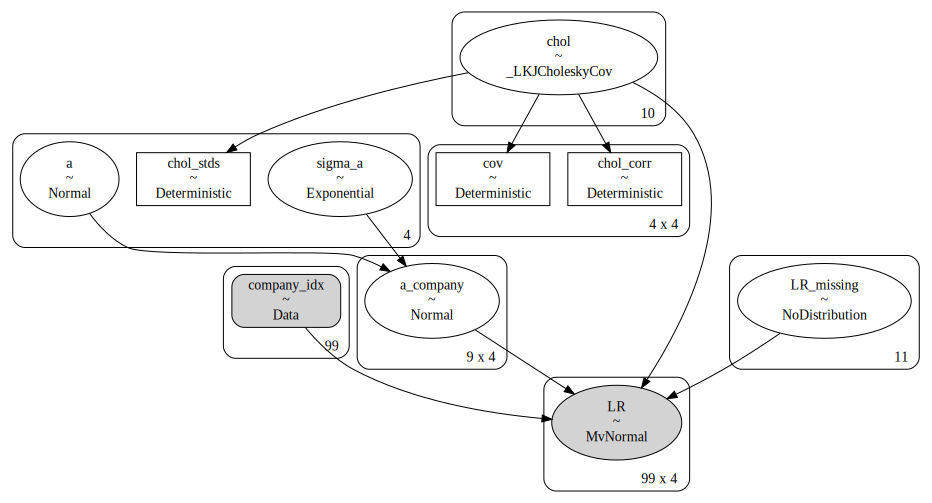

In [34]:
with pm.Model(coords=coords) as model_MvNormal:
    company_idx = pm.Data('company_idx',company_idxs,dims='obs_id')

    a = pm.Normal('a',mu=0.,sigma=5.,shape=4)
    sigma_a = pm.Exponential('sigma_a',1.,shape=4)
    a_company = pm.Normal('a_company',mu=a,sigma=sigma_a, dims=('company','region'))

    mu = a_company[company_idx]
    
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=4, eta =2.,
                                         sd_dist=pm.Exponential.dist(1.),compute_corr=True)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    
    LR = pm.MvNormal('LR',mu=mu, chol=chol, observed = data_transposed.iloc[:,2:])
pm.model_to_graphviz(model_MvNormal)

In [35]:
with model_MvNormal:
    trace = pm.sample(10000,tune=5000)
arviz.summary(trace)

<ipython-input-35-a2bcfa543f64>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000,tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LR_missing, chol, a_company, sigma_a, a]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 70 seconds.
There were 820 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1294 divergences after tuning. Increase `target_accept` or reparameterize.
There were 427 divergences after tuning. Increase `target_accept` or reparameterize.
There were 520 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/john/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.721,0.022,0.679,0.764,0.0,0.0,3491.0,3378.0,3371.0,4305.0,1.0
a[1],0.673,0.016,0.644,0.704,0.0,0.0,12483.0,12480.0,12045.0,10158.0,1.0
a[2],0.666,0.035,0.599,0.731,0.0,0.0,8381.0,8381.0,7968.0,3260.0,1.0
a[3],0.710,0.026,0.662,0.758,0.0,0.0,7042.0,7042.0,6302.0,11329.0,1.0
"a_company[0,0]",0.705,0.029,0.650,0.759,0.0,0.0,13676.0,13588.0,13336.0,11143.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"cov[2,3]",0.005,0.002,0.001,0.009,0.0,0.0,1756.0,1553.0,1914.0,5964.0,1.0
"cov[3,0]",0.001,0.002,-0.003,0.004,0.0,0.0,5168.0,5168.0,4810.0,14562.0,1.0
"cov[3,1]",0.002,0.001,0.000,0.005,0.0,0.0,6678.0,6678.0,6589.0,10768.0,1.0
"cov[3,2]",0.005,0.002,0.001,0.009,0.0,0.0,1756.0,1553.0,1914.0,5964.0,1.0
